<a href="https://colab.research.google.com/github/Helina-Yilma/Fintech-Analytics/blob/task-2/notebooks/sentiment_thematic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries if you haven't already
!pip install pandas torch transformers scipy scikit-learn spacy vaderSentiment
!python -m spacy download en_core_web_sm

In [ ]:
!git clone https://github.com/Helina-Yilma/Fintech-Analytics.git

In [ ]:
%cd "/content/Fintech-Analytics"

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import re
import spacy
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
df = pd.read_csv('data/processed/reviews_processed.csv')

In [ ]:
current_dir = os.getcwd()
print(f" current dir {current_dir}")

In [ ]:
df.head()

In [ ]:
# Initialize Models
bert_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
vader_analyzer = SentimentIntensityAnalyzer()

def get_hybrid_sentiment(text):
    # Truncate text to 512 tokens to prevent BERT errors
    text_sample = text[:512]

    # 1. Get VADER scores first (Good for neutrality)
    vader_scores = vader_analyzer.polarity_scores(text_sample)

    # If VADER compound score is clearly Neutral (-0.05 to 0.05), return Neutral
    if -0.05 <= vader_scores['compound'] <= 0.05:
        return "NEUTRAL", 0.0

    # 2. If not neutral, use BERT for high-quality binary classification
    try:
        bert_result = bert_pipeline(text_sample)[0]

        label = bert_result['label'] # 'POSITIVE' or 'NEGATIVE'
        score = bert_result['score']
        return label, score
    except:
        return "NEUTRAL", 0.0

# Apply to DataFrame (This may take time depending on dataset size
print("Running Sentiment Analysis...")
df[['sentiment_label', 'sentiment_score']] = df['review_text'].apply(lambda x: pd.Series(get_hybrid_sentiment(str(x))))

# --- AGGREGATION ---
print("\nAggregate Sentiment by Bank and Rating:")
agg_df = df.groupby(['bank_name', 'rating'])['sentiment_label'].value_counts(normalize=True).unstack()
print(agg_df.head())

In [ ]:
agg_df.tail(10)

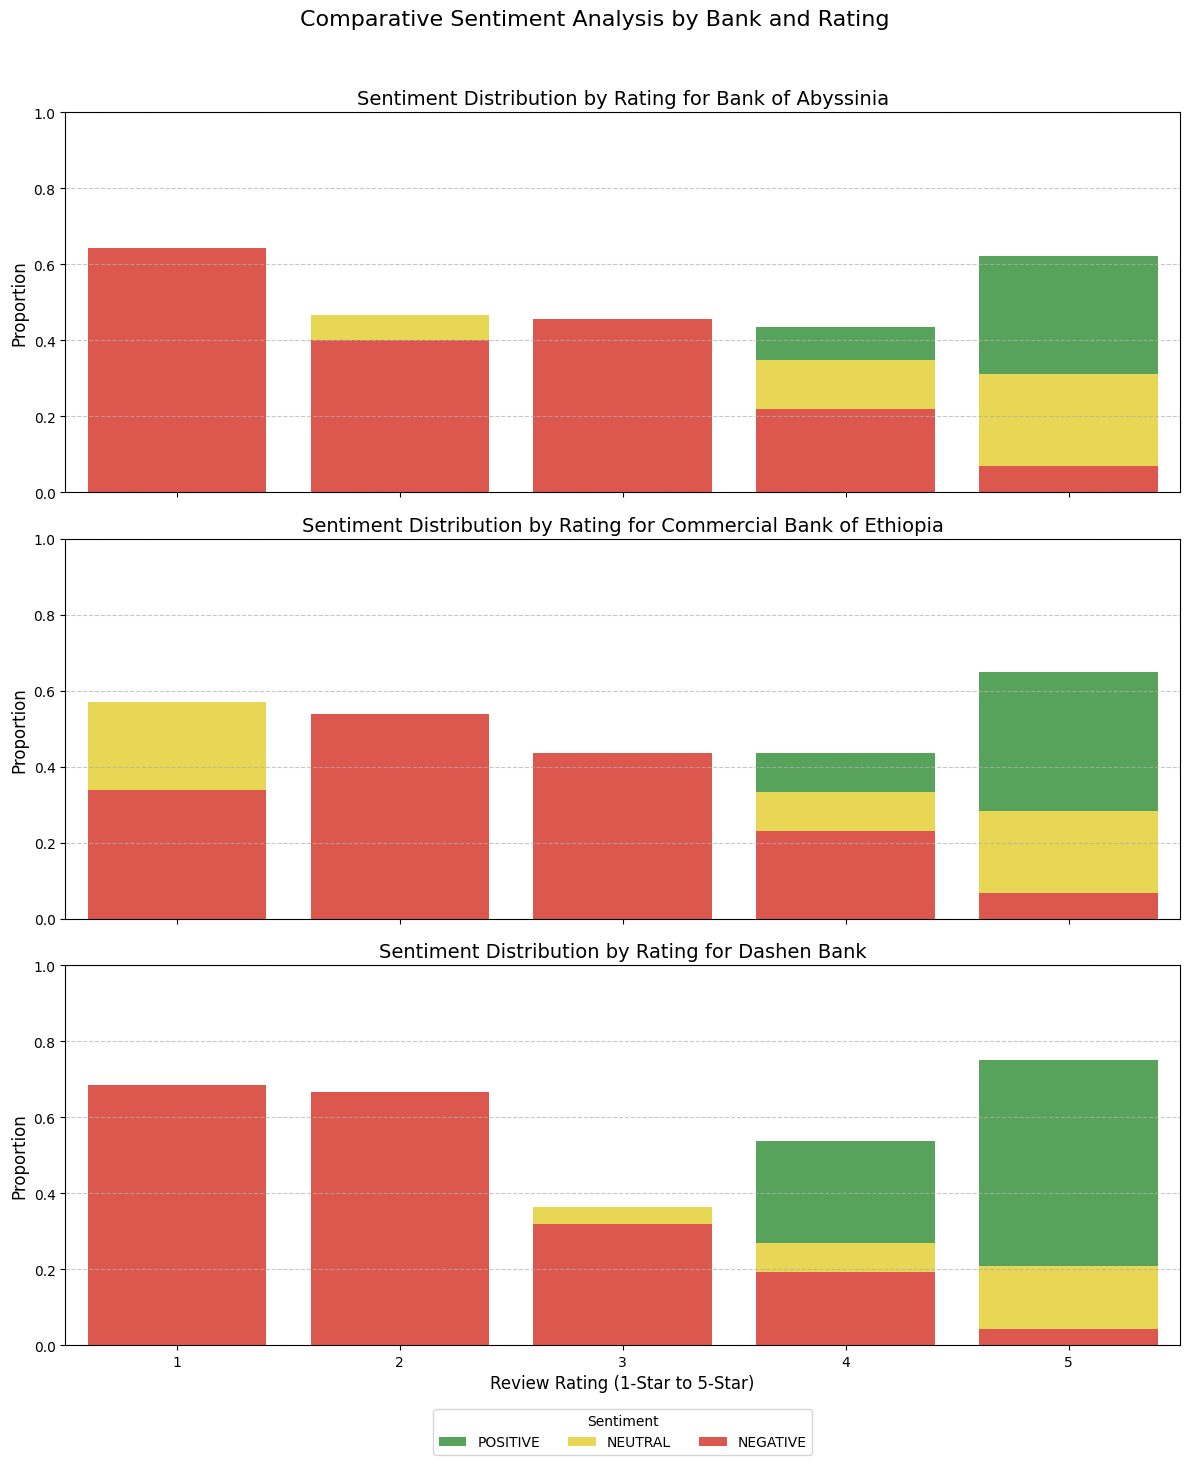

In [26]:

# Prepare data for Seaborn plotting
plot_df = agg_df.reset_index()

# Define the order of sentiment categories for consistent stacking and coloring
sentiment_order = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
sentiment_colors = ['#4CAF50', '#FFEB3B', '#F44336'] # Green, Yellow, Red

# Melt the DataFrame: This is crucial for creating stacked bar charts in Seaborn
plot_melt = plot_df.melt(id_vars=['bank_name', 'rating'],
                         value_vars=sentiment_order,
                         var_name='Sentiment',
                         value_name='Proportion')

# Set the correct order for sentiment in the melted data
plot_melt['Sentiment'] = pd.Categorical(plot_melt['Sentiment'], categories=sentiment_order, ordered=True)

# Identify unique banks for creating subplots
banks = plot_df['bank_name'].unique()
n_banks = len(banks)

# Create subplots for comparative analysis
fig, axes = plt.subplots(n_banks, 1, figsize=(12, 5 * n_banks), sharex=True)

# Ensure axes is iterable even if there is only one bank
if n_banks == 1:
    axes = [axes]

for i, bank in enumerate(banks):
    bank_data = plot_melt[plot_melt['bank_name'] == bank]

    # Create the stacked bar chart for the current bank
    sns.barplot(
        data=bank_data,
        x='rating',
        y='Proportion',
        hue='Sentiment',
        palette=sentiment_colors,
        dodge=False, # **Crucial for stacking the bars**
        ax=axes[i],
        order=sorted(plot_df['rating'].unique())
    )

    # Styling and labeling
    axes[i].set_title(f'Sentiment Distribution by Rating for {bank}', fontsize=14)
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].set_yticks(np.arange(0, 1.1, 0.2))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Handle legend placement
    if i < n_banks - 1:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(title='Sentiment', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        axes[i].set_xlabel('Review Rating (1-Star to 5-Star)', fontsize=12)

# Final plot title and layout adjustments
plt.suptitle('Comparative Sentiment Analysis by Bank and Rating', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 1.0])
plt.show() # Use plt.show() to display or plt.savefig() to save

In [ ]:
import pandas as pd
# Assuming 'df' is your DataFrame after Sen
# --- 1. Ensure a unique ID column is present (Optional but recommended) ---
# If you don't have one, create a simple index
if 'review_id' not in df.columns:
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'review_id'}, inplace=True)

# --- 2. Define the columns to save ---
# Include the original data plus the new sentiment columns
columns_to_save = [
    'review_id',
    'review_text',
    'rating',
    'bank_name',
    'source',
    'sentiment_label',
    'sentiment_score'
]

# --- 3. Save the DataFrame to a CSV file ---
output_path = 'data/processed//reviews_with_sentiment.csv'

try:
    df[columns_to_save].to_csv(output_path, index=False)
    print(f"Sentiment results saved successfully to: {output_path}")
except Exception as e:
    print(f"Error saving file: {e}")

In [ ]:
df.info()

## Thematic Analysis

In [ ]:

nlp = spacy.load("en_core_web_sm")

def preprocess_for_tfidf(text):
    """
    Cleans, tokenizes, removes stop words, and optionally lemmatizes the text.
    """
    if not isinstance(text, str): return ""

    # 1. Cleaning
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation/numbers

    # 2. Tokenization, Stopword Removal, and Lemmatization
    doc = nlp(text)

    # Use lemmatization and filter out stop words and non-alpha tokens
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and token.is_alpha and len(token.text) > 2
    ]

    return " ".join(tokens)

df['clean_text_for_theme'] = df['review_text'].apply(preprocess_for_tfidf)

In [ ]:

banks = ['CBE', 'BOA', 'Dashen']
top_n_keywords = 20

# Dictionary to store the most significant keywords for manual grouping
bank_keywords = {}

for bank in banks:
    # Filter reviews for the current bank
    bank_reviews = df[df['bank_code'] == bank]['clean_text_for_theme']

    # Initialize TF-IDF Vectorizer
    # ngram_range=(1, 3) captures single words, two-word phrases, and three-word phrases
    tfidf = TfidfVectorizer(ngram_range=(1, 3), max_df=0.85, min_df=5)

    try:
        dtm = tfidf.fit_transform(bank_reviews)
        feature_names = tfidf.get_feature_names_out()

        # Calculate the sum of TF-IDF scores for each term across all reviews
        sum_scores = dtm.sum(axis=0)
        sorted_indices = np.argsort(sum_scores)[0, ::-1].A1

        # Get the top N terms
        top_terms = [feature_names[i] for i in sorted_indices[:top_n_keywords]]
        bank_keywords[bank] = top_terms

    except ValueError:
        print(f"Not enough data to calculate TF-IDF for {bank}")

print(bank_keywords) # Review this output manually to define your rules

In [ ]:
# Define the dictionary based on your manual review of the TF-IDF output
theme_keywords = {
    'Account Access Issues': ['login', 'otp', 'password', 'verify'],
    'Transaction Performance': ['transfer', 'slow', 'pending', 'fail'],
    'Reliability / Bugs': ['crash', 'bug', 'error', 'close'],
    'User Interface & Experience': ['ui', 'design', 'confuse', 'navigate'],
    'Customer Support': ['support', 'call', 'service', 'help']
}

def assign_themes(text):
    """
    Assigns theme labels based on the presence of predefined keywords in the text.
    """
    identified_themes = set()

    for theme, keywords in theme_keywords.items():
        if any(keyword in text for keyword in keywords):
            identified_themes.add(theme)

    # Return as a comma-separated string
    return ", ".join(sorted(list(identified_themes))) if identified_themes else "General/Other"

# Apply the theme assignment to the cleaned text used for TF-IDF
df['identified_theme(s)'] = df['clean_text_for_theme'].apply(assign_themes)

print(df[['review_text', 'identified_theme(s)']].head())

In [ ]:

final_columns = [
    'review_id', 'review_text', 'bank_name', 'rating',
    'sentiment_label', 'sentiment_score', 'identified_theme(s)'
]

df['review_id'] = df.index # Use index as ID if not already present

df[final_columns].to_csv('data/processed/processed_reviews.csv', index=False)

In [ ]:
df.info()

In [ ]:
df = df.rename(columns={'identified_theme(s)': 'themes'})

In [ ]:
df.info()

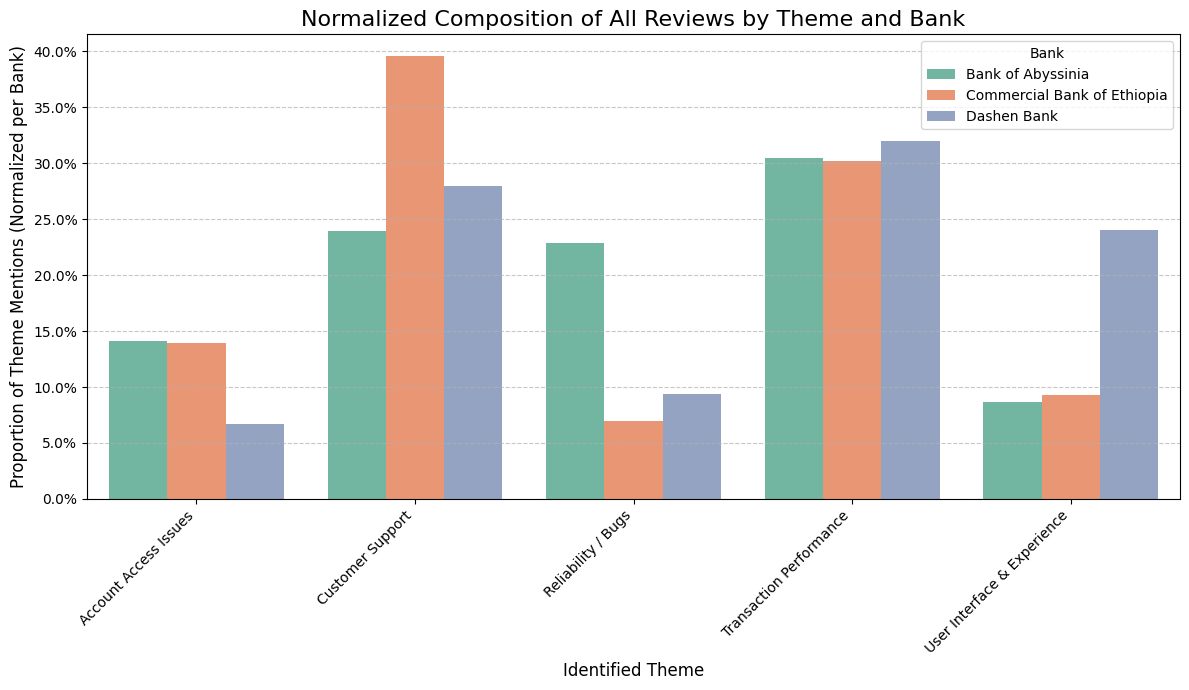

In [25]:

# --- 1. AGGREGATION & NORMALIZATION ---

# Explode the themes to get one row per theme mention
theme_counts_all = df.assign(theme=df['themes'].str.split(', ')).explode('theme')

theme_counts_all['theme'] = theme_counts_all['theme'].str.strip()
theme_counts_all = theme_counts_all[theme_counts_all['theme'] != 'General/Other']

# Calculate the raw count of each theme per bank
theme_summary_all = theme_counts_all.groupby(['bank_name', 'theme']).size().reset_index(name='count')

# Calculate the total theme mentions for each bank (the denominator for normalization)
bank_totals = theme_summary_all.groupby('bank_name')['count'].sum()

# Merge the totals back and calculate the PROPORTION
theme_summary_norm = theme_summary_all.merge(bank_totals.rename('total_count'), on='bank_name')
theme_summary_norm['Proportion'] = theme_summary_norm['count'] / theme_summary_norm['total_count']


# --- 2. VISUALIZATION: Grouped Bar Chart (Best Choice) ---
plt.figure(figsize=(12, 7))

sns.barplot(
    data=theme_summary_norm,
    x='theme',
    y='Proportion',
    hue='bank_name', # Group by bank name
    palette='Set2'
)

# Styling and labels
plt.title('Normalized Composition of All Reviews by Theme and Bank', fontsize=16)
plt.xlabel('Identified Theme', fontsize=12)
plt.ylabel('Proportion of Theme Mentions (Normalized per Bank)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Bank', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0)) # Format Y-axis as percentage

plt.tight_layout()
plt.show()

In [ ]:
# --- Define the desired output columns for the final file ---
# Ensure you include the thematic column(s) that were just added.
final_columns = [
    'review_id',
    'review_text',
    'bank_name',
    'rating',
    'sentiment_label',
    'sentiment_score',
    'themes'
]

# --- Save the DataFrame to reviews_final.csv ---
output_path = 'data/reviews_final.csv'

try:
    df[final_columns].to_csv(output_path, index=False)
    print(f"Final processed data saved successfully to: {output_path}")

except KeyError as e:
    print(f"ERROR: Column {e} not found in DataFrame. Double-check your column names!")
except Exception as e:
    print(f"Error saving file: {e}")